DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000020303BA9E80>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000020303BA9E80> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


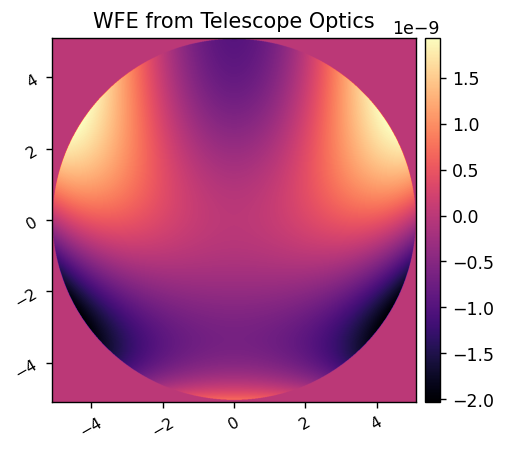

In [2]:
import numpy as np
import scipy
import poppy
if poppy.accel_math._USE_CUPY:
    import cupy as xp
    import cupyx.scipy as _scipy
else:
    xp = np
    _scipy = scipy
    
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from prop_models import full, compact, agpm
reload(full)
reload(compact)
reload(agpm)

from wfsc_1dm import efc, pwp, utils

import misc_funs as misc

pupil_diam = 10.2*u.mm
wavelength_c = 750e-9*u.m

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

lyot_stop_physical = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm)
lyot_stop_compact = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm * 500/350)

hdr = fits.getheader('wfe_on_axis.fits')
ote_wfe = poppy.FITSOpticalElement(opd='wfe_on_axis.fits', opdunits='meters',
                                   pixelscale=pupil_diam.to_value(u.m)/hdr['NAXIS1'])
misc.imshow1(ote_wfe.opd, 'WFE from Telescope Optics', pxscl=ote_wfe.pixelscale.to(u.mm/u.pix))



# Generate pointing error distribution.

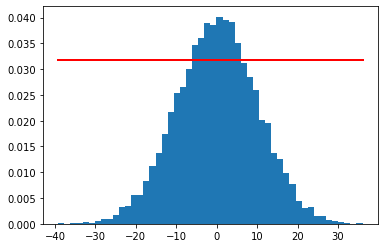

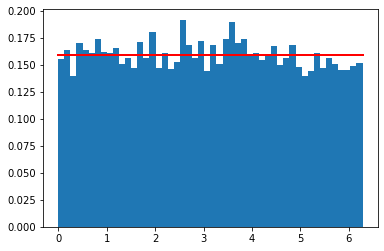

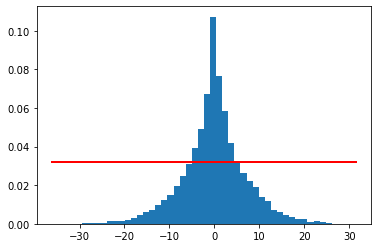

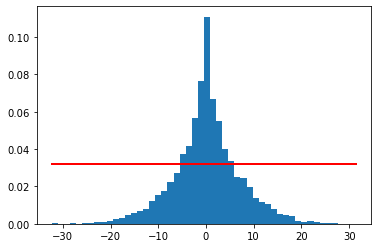

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarLogLocator object at 0x000002030EA038B0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarLogLocator object at 0x000002030EA038B0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.ticker:vmin 4.0623685533557533e-05 vmax 0.01462452679208071
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 4.0623685533557533e-05 vmax 0.01462452679208071
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 4.0623685533557533e-05 vmax 0.01462452679208071
DEBUG:matplotlib.ticker:ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.

DEBUG:matplotlib.ticker:vmin 4.0623685533557533e-05 vmax 0.01462452679208071
DEBUG:matplotlib.ticker:ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00])
DEBUG:matplotlib.ticker:vmin 4.0623685533557533e-05 vmax 0.01462452679208071
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 4.0623685533557533e-05 vmax 0.01462452679208071
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 4.0623685533557

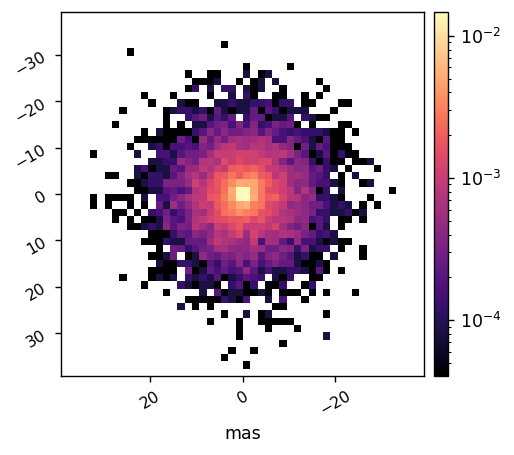

In [71]:
pointing_error = 10*u.mas # STD of pointing error
mean = 0

seed = 123

pointing_r = np.random.default_rng(seed).normal(mean, pointing_error.to_value(u.mas), 10000)
pointing_th = np.random.default_rng(seed).uniform(low=0.0, high=2*np.pi, size=10000)

pointing_x = pointing_r*np.cos(pointing_th)
pointing_y = pointing_r*np.sin(pointing_th)

pointing = np.array([pointing_x, pointing_y]).T

nbins = 50

fig = plt.figure()
count, bins, ignored = plt.hist(pointing_r, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.close()
display(fig)

fig = plt.figure()
count, bins, ignored = plt.hist(pointing_th, nbins, density=True)
plt.plot(bins, 1/(2*np.pi)*np.ones_like(bins), linewidth=2, color='r')
plt.close()
display(fig)

fig = plt.figure()
count, bins, ignored = plt.hist(pointing_x, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.close()
display(fig)

fig = plt.figure()
count, bins, ignored = plt.hist(pointing_y, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.close()
display(fig)

rmax = np.max(np.abs(pointing_r))
fig = plt.figure()
h, xedges, yedges, im = plt.hist2d(pointing_x, pointing_y, bins=nbins, range=[[-rmax, rmax], [-rmax, rmax]], density=True)
plt.close()

misc.imshow1(h, lognorm=True, pxscl=(xedges[0]-xedges[1]), xlabel='mas')


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030D09BDC0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030D09BDC0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


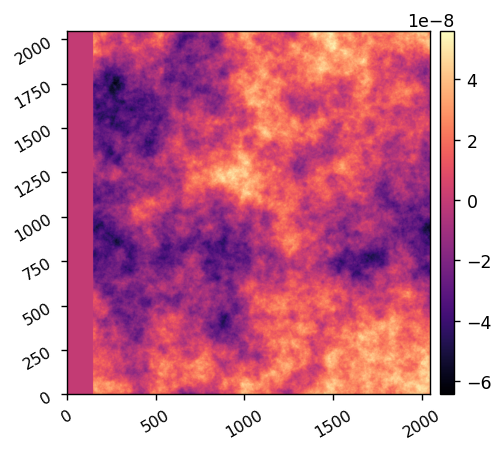

In [90]:
def shift_surface_errors(surf, wf, x_shift=0*u.m, y_shift=0*u.m):
    
    surf_opd = surf.get_opd(wf)
    x_shift_pix = x_shift.to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
    y_shift_pix = y_shift.to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
    
    shifted_surf = _scipy.ndimage.shift(surf_opd, (y_shift_pix,x_shift_pix))
    return shifted_surf

arr = shift_surface_errors(m2surf, m2wf, x_shift=5*u.cm)
misc.imshow1(arr)

DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000202E0B2B250>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000202E0B2B250> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


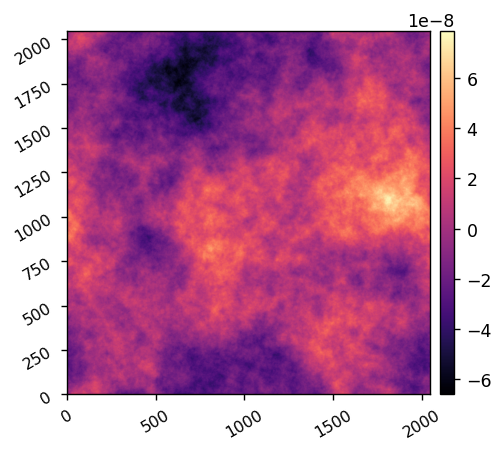

DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000020306F9E850>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000020306F9E850> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


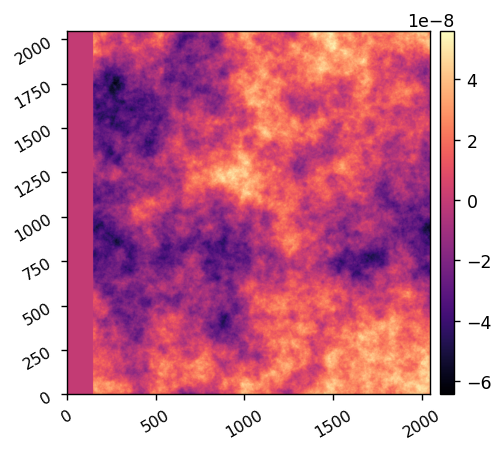

DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030CD64460>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030CD64460> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


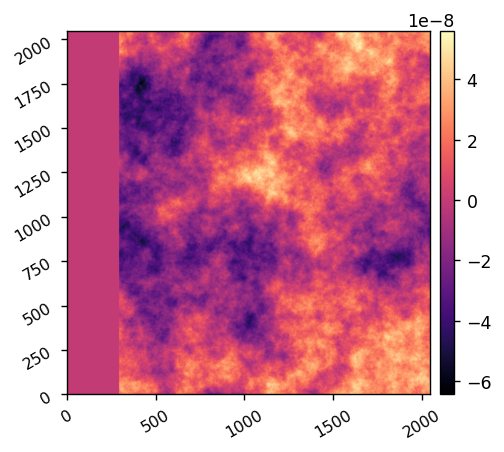

DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030E2FCBB0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030E2FCBB0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


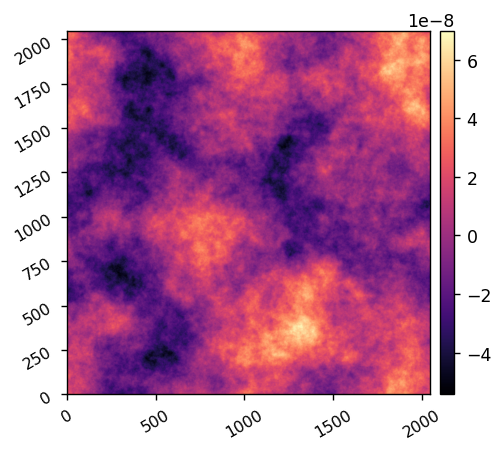

In [97]:
poppy_log.disabled = False

m1_diam = 6.5*u.m
m2_diam = 700*u.mm
m3_diam = 800*u.mm # using the maximum dimension of M3 to define the surface opd
m3_dims = [800*u.mm, 700*u.mm]

m4_diam = 100*u.mm

seeds = (1,2,3,4)

m4surf = poppy.StatisticalPSDWFE('M4 Surface OPD', index=3.0, wfe=20*u.nm, radius=m4_diam/2, seed=seeds[3])

npix = 2048 # use high-sampling when we are defining the surface errors
oversample = 1

m1surf = poppy.StatisticalPSDWFE('M1 Surface OPD', index=3.0, wfe=20*u.nm, radius=m1_diam/2, seed=seeds[0])
m1wf = poppy.FresnelWavefront(beam_radius=m1_diam/2, npix=npix, oversample=oversample)
m1errs = m1surf.get_opd(m1wf) # m1 
misc.imshow1(m1errs)

m2surf = poppy.StatisticalPSDWFE('M2 Surface OPD', index=3.0, wfe=20*u.nm, radius=m2_diam/2, seed=seeds[1])
m2wf = poppy.FresnelWavefront(beam_radius=m2_diam/2, npix=npix, oversample=oversample)
# m2_shift = get_chief_ray_shift('m2')
m2_shift = (5*u.cm,0*u.cm)
m2surf = poppy.ArrayOpticalElement(opd=shift_surface_errors(m2surf, m2wf, x_shift=m2_shift[0], y_shift=m2_shift[1]))
misc.imshow1(m2surf.opd)

m3surf = poppy.StatisticalPSDWFE('M3 Surface OPD', index=3.0, wfe=20*u.nm, radius=m3_diam/2, seed=seeds[2])
m3wf = poppy.FresnelWavefront(beam_radius=m3_diam/2, npix=npix, oversample=oversample)
# m2_shift = get_chief_ray_shift('m2')
m3_shift = (5*u.cm,0*u.cm)
m3surf = poppy.ArrayOpticalElement(opd=shift_surface_errors(m2surf, m2wf, x_shift=m2_shift[0], y_shift=m2_shift[1]))
misc.imshow1(m3surf.opd)

m4surf = poppy.StatisticalPSDWFE('M4 Surface OPD', index=3.0, wfe=20*u.nm, radius=m4_diam/2, seed=seeds[3])
m4wf = poppy.FresnelWavefront(beam_radius=m4_diam/2, npix=npix, oversample=oversample)
m4errs = m4surf.get_opd(m4wf)
misc.imshow1(m4errs)


<Quantity 1.65276262e-05 m>

<Quantity 39.11884125 m>

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarLogLocator object at 0x000002030E3DFA30>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarLogLocator object at 0x000002030E3DFA30> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002032C02E640>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002032C02E640> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.ticker:vmin 7.108688957947713e-11 vmax 2.5550667245597194
DEBUG:matplotlib.ticker:ticklocs array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
       1.e+03])
DEBUG:matplotlib.ticker:vmin 7.108688957947713e-11 vmax 2.5550667245597194
DEBUG:matplotlib.ticker:ticklocs array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
       1.e+03])
DEBUG:matplotlib.ticker:vmin 7.1

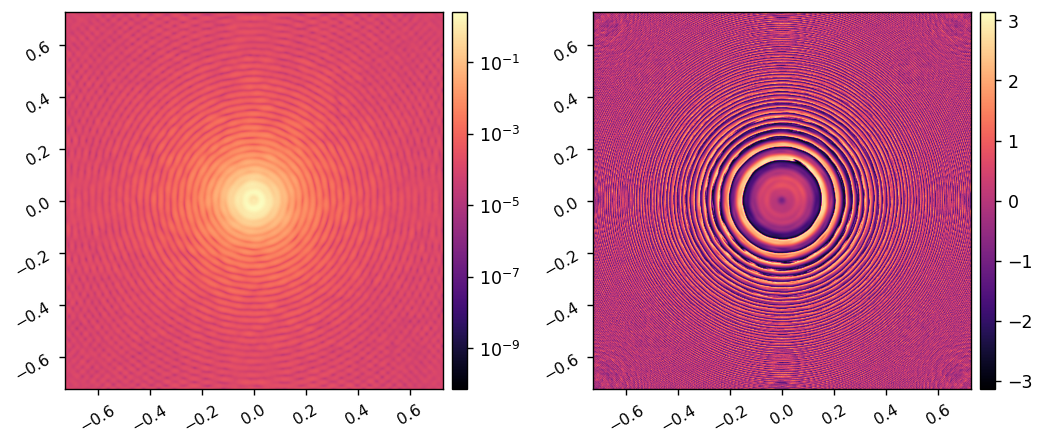

In [106]:
poppy_log.disabled = True

npix = 256
oversample = 8
pupil_diam = m1_diam
PUPIL = poppy.CircularAperture(radius=pupil_diam/2)

fl_m1 = 3.652962023674745E+004/2*u.mm
fl_m2 = -3.636649801410836E+003/2*u.mm
fl_m3 = 3.463978665836946E+003/2*u.mm

m1 = poppy.QuadraticLens(fl_m1, name='M1')
m2 = poppy.QuadraticLens(fl_m2, name='M2')
m3 = poppy.QuadraticLens(fl_m3, name='M3')
m4 = poppy.ScalarTransmission()

fosys = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix, beam_ratio=1/oversample)
fosys.add_optic(PUPIL)
fosys.add_optic(m1)
fosys.add_optic(m1surf)
fosys.add_optic(m2, distance=1.663812910134875E+004*u.mm)
fosys.add_optic(m2surf)
fosys.add_optic(m3, distance=(16500+2000)*u.mm)
fosys.add_optic(m3surf)
fosys.add_optic(m4, distance=1.895000000000000E+003*u.mm)
fosys.add_optic(m4surf)
fosys.add_optic(poppy.ScalarTransmission('Image'), distance=2.091997751264193E+003*u.mm + 0*u.mm)

_, wfs = fosys.calc_psf(wavelength=750*u.nm, return_intermediates=True, normalize='none')

clear_output()
display(wfs[-1].w_0, wfs[-1].z_w0)
misc.imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, pxscl=wfs[-1].pixelscale.to_value(u.mm/u.pix))

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000020323C77B50>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000020323C77B50> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030E638CA0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002030E638CA0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


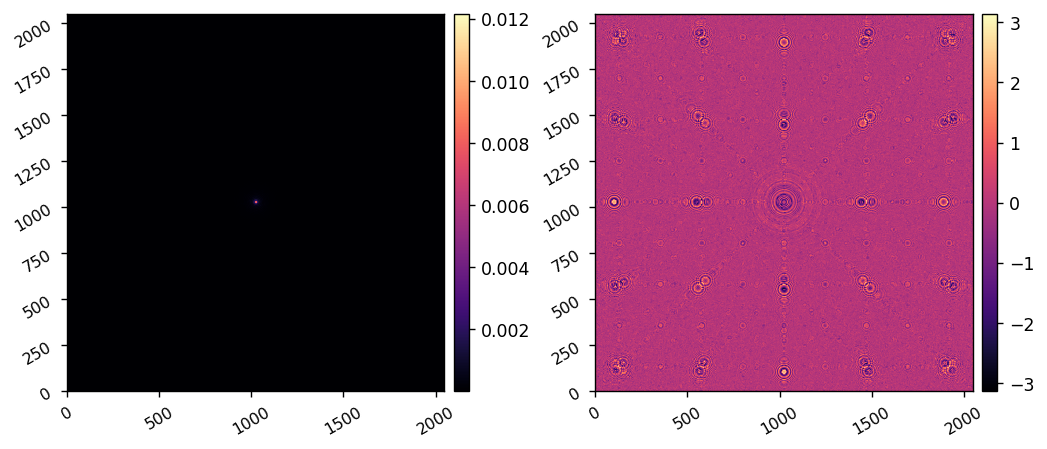

In [107]:
pupil = xp.fft.ifftshift(xp.fft.ifft2(xp.fft.fftshift(wfs[-1].wavefront)))

misc.imshow2(np.abs(pupil), np.angle(pupil))

<Quantity 0.00634766 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5c9afa30>
DEBUG:matplotlib.colorbar:colorbar update normal <matplotlib.colors.Normalize object at 0x7efe5d20d8e0> <matplotlib.colors.Normalize object at 0x7efe5d20d8e0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5cad95e0>
DEBUG:matplotlib.colorbar:colorbar update normal <matplotlib.colors.Normalize object at 0x7efe5d20d8e0> <matplotlib.colors.Normalize object at 0x7efe5d20d8e0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5cad95e0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5cbf39a0>


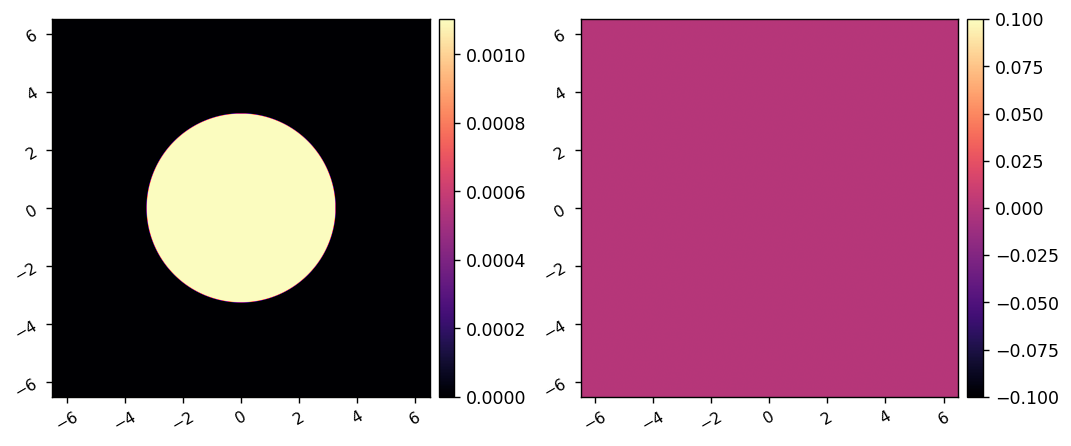

<Quantity 0.00634766 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe7418cc40>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe741cdbb0>


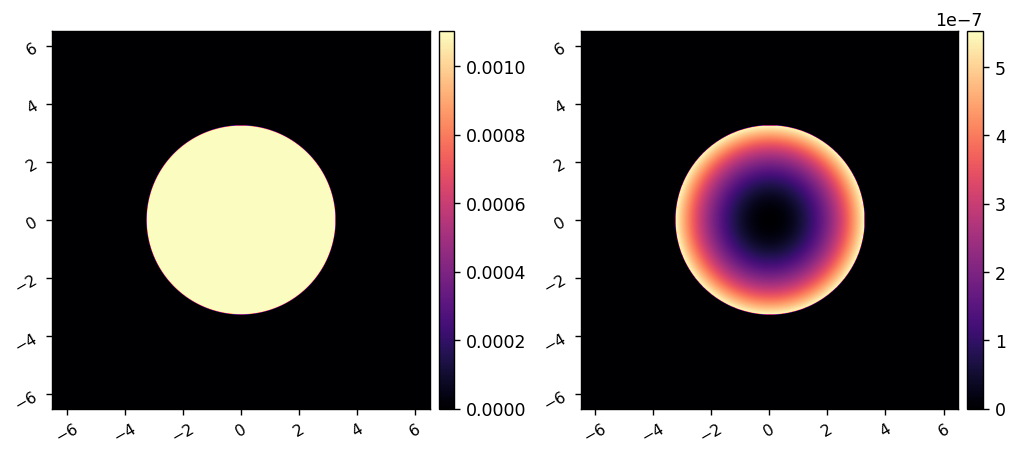

<Quantity 0.00634766 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe744d4c10>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe744f9160>


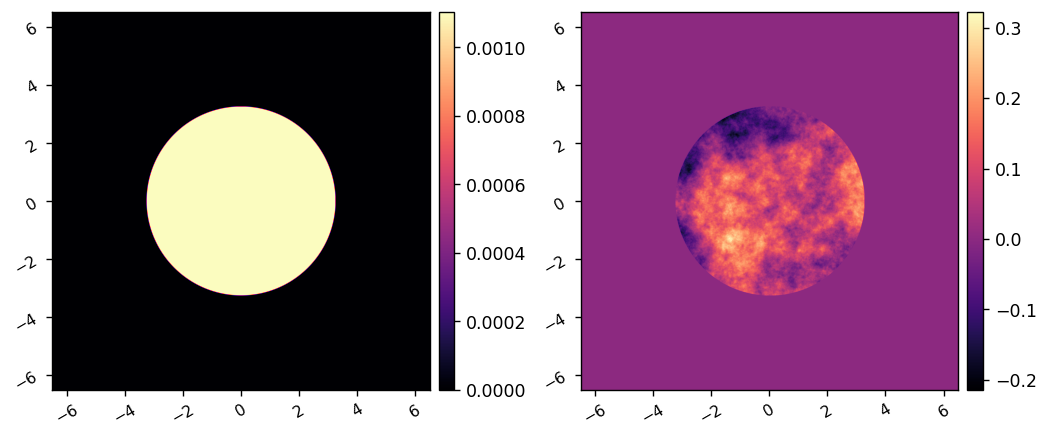

<Quantity 0.00056533 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe7484d610>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe742792e0>


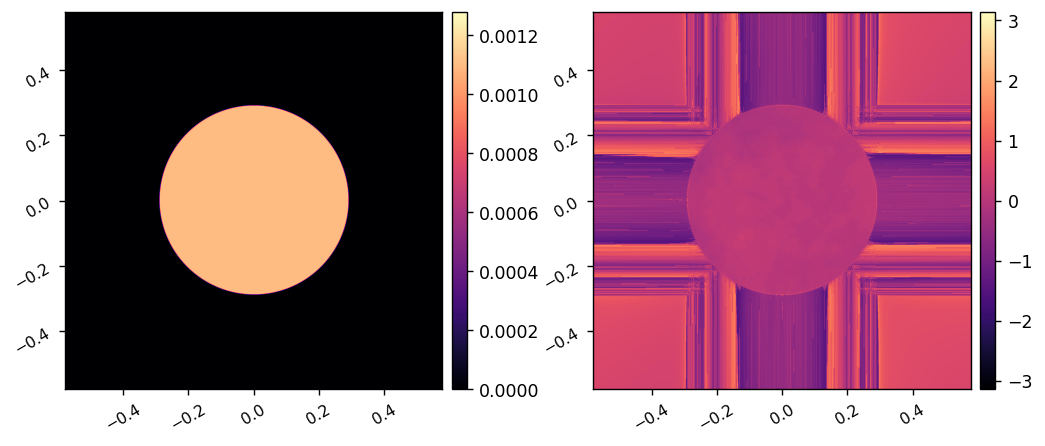

<Quantity 0.00056533 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5d2c0580>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe74181e50>


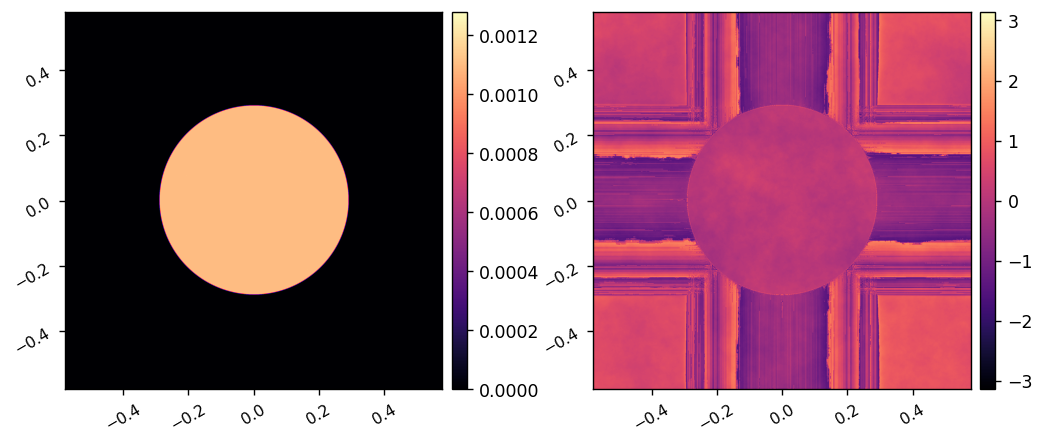

<Quantity 0.0001123 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe74275220>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe74333a90>


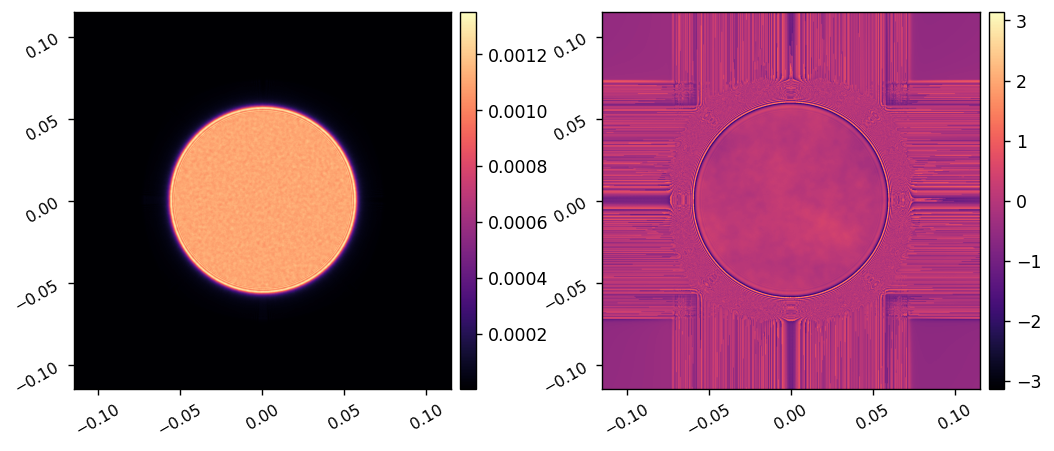

<Quantity 0.0001123 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5c8ba8e0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5ca99190>


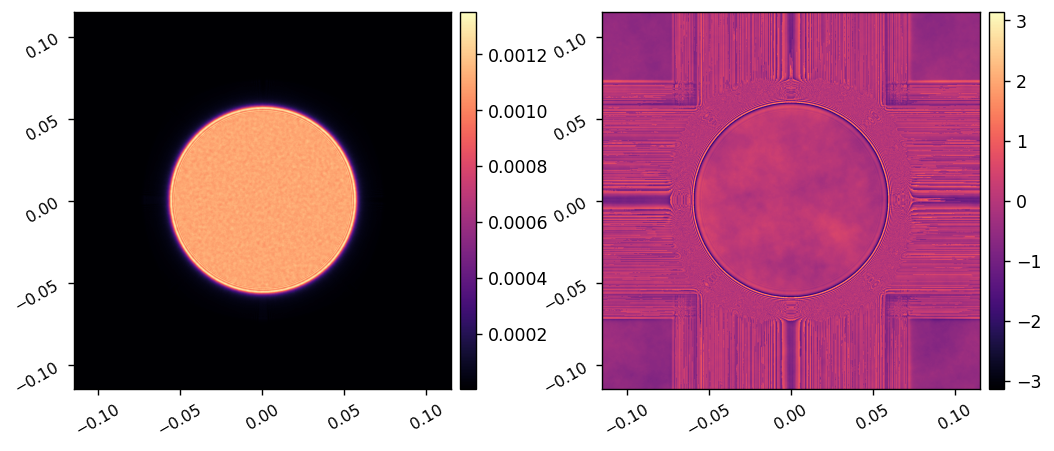

<Quantity 5.88417093e-05 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe746cc1c0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe741e8a30>


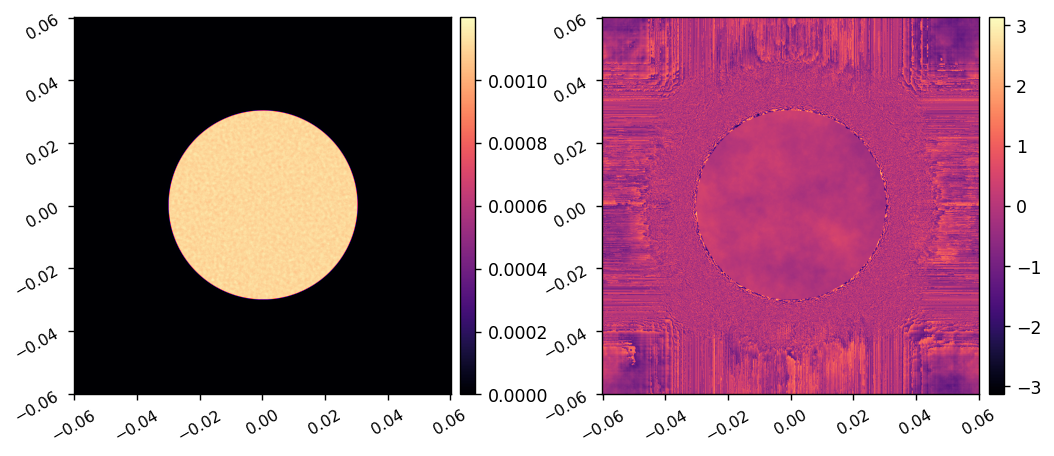

<Quantity 5.88417093e-05 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe742b43d0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5d455e50>


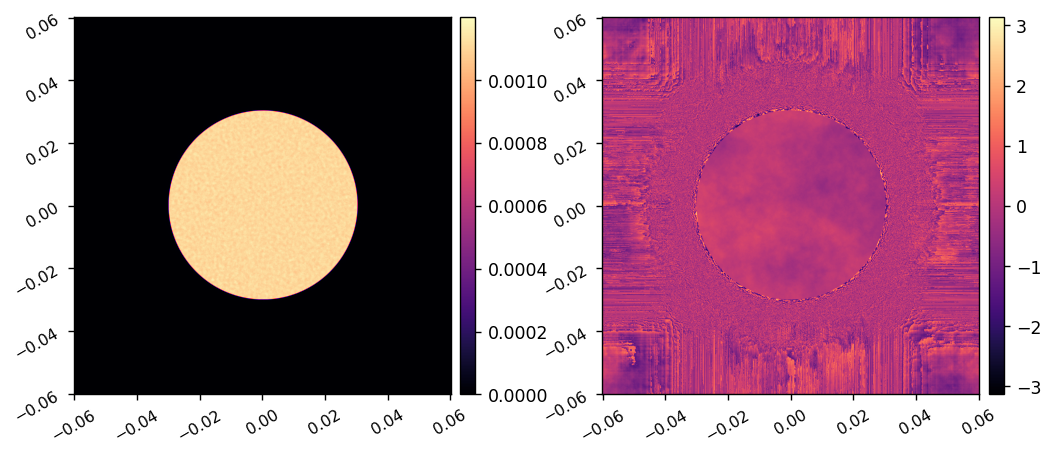

<Quantity 1.77342159e-07 m / pix>

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5d6677f0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe5d77b2b0>


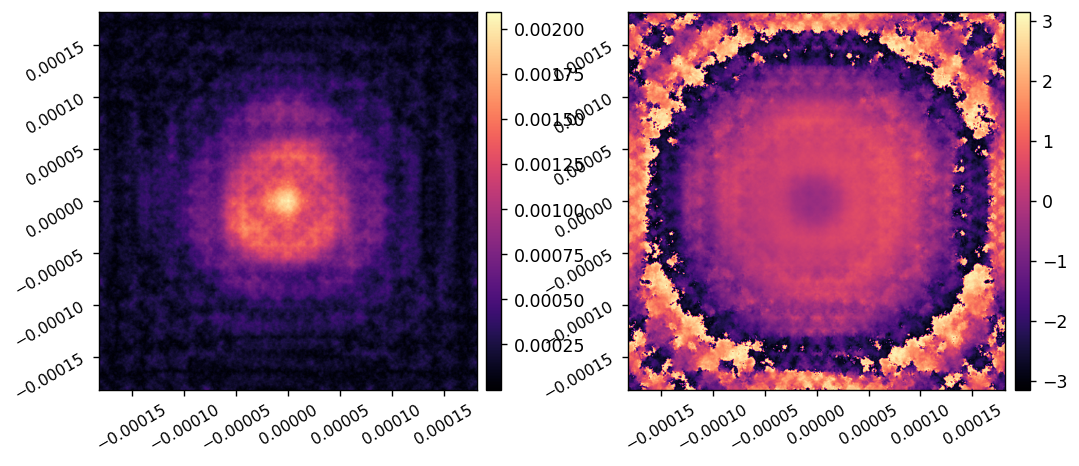

In [29]:
for i in range(len(wfs)):
    display(wfs[i].pixelscale)
    misc.imshow2(wfs[i].amplitude, wfs[i].phase, pxscl=wfs[i].pixelscale)